## Timing

In [1]:
import time
st=time.time()

This notebook runs Lume-Impact to L0AFEND, Bmad from there.

## Import Statements

In [2]:
import numpy as np
from distgen import Generator
from impact import Impact, run_impact_with_distgen, evaluate_impact_with_distgen
from impact.autophase import autophase_and_scale
import os
from pmd_beamphysics import single_particle, ParticleGroup

from pytao import Tao
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import re
import io
from os import path,environ
import pandas as pd
import h5py
import pmd_beamphysics
import glob
import concurrent.futures
import copy
import yaml
import pickle

import impact
import xopt


from pmd_beamphysics.statistics import resample_particles

%run -i helper_funcs.py
os.environ['OMP_NUM_THREADS']=str(len(os.sched_getaffinity(0))-1)
!echo $OMP_NUM_THREADS

119


## Set Environment Variables

In [3]:
os.environ['FACET2_LATTICE']=os.path.expanduser('~/facet2-lattice/')
!echo $FACET2_LATTICE
print('Make sure enviornment was set!:  ', os.environ['FACET2_LATTICE']) 
!echo $SCRATCH

/sdf/home/c/cropp/facet2-lattice/
Make sure enviornment was set!:   /sdf/home/c/cropp/facet2-lattice/
/sdf/scratch/users/c/cropp


## Define Inputs


In [4]:
NAME = '1.6nC_s2e_200k_Timing_Test' #folder to be created that holds all results
FILEPATH='/sdf/data/ad/ard/u/cropp/Sol_Scan_FACET1/' # Above folder created in this location
filename='Sol_Scan1.json' #Solenoid scan output name

GFILE = os.path.expandvars('distgen.yaml') # Distgen input file
YFILE = os.path.expandvars('ImpactT.yaml') # To be created based on template and updated for final run
YFILE_TEMPLATE = os.path.expandvars('ImpactT-template.yaml') #Initial settings

L0AF_E_Gain=62924849.46502216 # Calculated L0AF energy gain from January 2024 nominal power readbacks
L0BF_E_Gain=60473730.43463376 # Calculated L0BF energy gain from January 2024 nominal power readbacks
sim_sol_conv=1.6 #Convert from PV value to T/m (simulation input)
L0AF_Phase=0 #L0AF phase; 0 is max E phase

sim_sol_conv=1.6

Bmad_Settings={}
# Define energy setpoints at exit of L0 L1 L2 in eV
Bmad_Settings['L0energy'] = 0.125e9;    
Bmad_Settings['L1energy'] = 0.338e9;
Bmad_Settings['L2energy'] = 4.5e9;

# Define L1 and L2 phases in deg
Bmad_Settings['L1phase'] = -17;
Bmad_Settings['L2phase'] = -41.5;

#Injector quads
Bmad_Settings['QA10361:b1_gradient'] = 2.985123	
Bmad_Settings['QA10371:b1_gradient'] = -2.824138	
Bmad_Settings['QE10425:b1_gradient'] = 5.964119	
Bmad_Settings['QE10441:b1_gradient'] = -6.215696	
Bmad_Settings['QE10511:b1_gradient'] = 2.41815	
Bmad_Settings['QE10525:b1_gradient'] = 3.240741	
Bmad_Settings['L0BF_E_Gain'] = L0BF_E_Gain
Bmad_Settings['L0BF_Phase:theta0_deg'] = -10;

#CSR for Bmad
Bmad_CSR_Command = 'csroff' #or csron

#Bmad output locations
locations = ['L0AFEND','L0BFEND','BC11CBEG','BC11CEND',
             'BEGBC14_1','ENDBC14_2','BEGBC20','PENT']; #Bmad output locations

#Impact settings
SETTINGS0 = {
    'numprocs':(len(os.sched_getaffinity(0)))-1, #Number of available cores, minus one (jupyter is running in one core)
    'header:Nx':16,
    'header:Ny':16,  
    'header:Nz':16, 
    'stop_1:s':4.2,
    'distgen:n_particle':2e4,
    'GUNF:theta0_deg':26.8-90.5,#30 degrees-adjustment for phase def.
    'GUNF:rf_field_scale': 123/2.44885*1e6,
    'SOL10111:solenoid_field_scale':-0.41/sim_sol_conv,
    'PR10241:sample_frequency':1,
    'workdir':os.path.expandvars('$SCRATCH'),
    'command': '/sdf/home/c/cropp/conda/envs/xopt/bin/ImpactTexe',    
    'command_mpi': '/sdf/home/c/cropp/conda/envs/xopt/bin/ImpactTexe-mpi',
    # 'mpi_run':'salloc --partition milano --account ad:ard-online -N 1 -n {nproc} /usr/lib64/openmpi/bin/mpirun -n {nproc} {command_mpi}'
    'mpi_run':'/usr/lib64/openmpi/bin/mpirun --oversubscribe -n {nproc} {command_mpi}'
}

#Solenoid scan settings
smin=0.3
smax=0.45
sstep=0.001


filepath=FILEPATH+NAME
try:
    os.mkdir(FILEPATH)
except:
    pass
try:
    os.mkdir(filepath)
except:
    pass

## Copy Impact Input Files to Directory

In [5]:
!cp $FACET2_LATTICE/impact/models/f2e_inj/v0/ImpactT_template.in .
!cp $FACET2_LATTICE/impact/models/f2e_inj/v0/rfdata201 .
!cp $FACET2_LATTICE/impact/models/f2e_inj/v0/rfdata102 .
!cp $FACET2_LATTICE/impact/models/f2e_inj/v0/rfdata4 .
!cp $FACET2_LATTICE/impact/models/f2e_inj/v0/rfdata5 .
!cp $FACET2_LATTICE/impact/models/f2e_inj/v0/rfdata6 .
!cp $FACET2_LATTICE/impact/models/f2e_inj/v0/rfdata7 .

## Update Distgen and Impact Objects

In [6]:
I = Impact.from_yaml(YFILE_TEMPLATE)
G = Generator(GFILE)
I=update_impact(I,SETTINGS0)


## Make a copy of the Impact object and track it to determine energy at exit of gun
Do not track on the original Impact object; boundary conditions will not match the desired from above

In [7]:
I2=copy.deepcopy(I)

P0 = pmd_beamphysics.single_particle(pz=1e-15, z=1e-15)


I2.numprocs=1
t=I2.track(P0,s=0.9)

E=t['mean_energy']
print(E)

6277840.0749794515


## Autophase & Scale L0AF

In [8]:
I['L0AF_scale']['rf_field_scale']=30e6
I['L0AF_phase']['theta0_deg']=29
I.numprocs=1

target_L0AF=E+L0AF_E_Gain

print(target_L0AF)

res_L0AF = impact.autophase.autophase_and_scale(I, phase_ele_name='L0AF_phase', scale_ele_name='L0AF_scale', target=target_L0AF, scale_range=(10e6, 100e6), initial_particles=P0, verbose=True)


69202689.54000162
Copied initial Impact object. 
Phasing L0AF_phase by changing theta0_deg
Scaling L0AF_scale by changing rf_field_scale
Bounds: 1.058398, 4.101254 m
Tracking initial particles to s = 1.058398
Initial particle:  1.05790393743 6277840.0749794515
Disabling GUNF
Disabling SOL10111
Disabling L0BF_entrance
Disabling L0BF_body_1
Disabling L0BF_body_2
Disabling L0BF_exit
Default brent2 algorithm
Phase: 180, Scale: 10000000.0, 13.884908067191025 MeV
Phase: 180, Scale: 10000000.0, 13.884908067191025 MeV
Phase: 42.49224000000004, Scale: 10000000.0, 19.472839721833132 MeV
Phase: 264.9844890561601, Scale: 10000000.0, 9.13965596507301 MeV
Phase: 42.49224000000004, Scale: 10000000.0, 19.472839721833132 MeV
Phase: 42.49223440298533, Scale: 10000000.0, 19.47284119061983 MeV
Phase: 264.9844709438398, Scale: 10000000.0, 9.139652577562334 MeV
Phase: 222.4922627871657, Scale: 10000000.0, 9.516210148212714 MeV
Phase: 127.47670402554945, Scale: 10000000.0, 8.61015493402449 MeV
Phase: 333.738

## Adjust phase given settings specified above

In [9]:
I['L0AF_phase']['theta0_deg']=I['L0AF_phase']['theta0_deg']-L0AF_Phase



## Make initial distribution


In [10]:
G=update_distgen(G,SETTINGS0,verbose=True)
G.input
G.run()
P = G.particles
I.initial_particles = P

Setting distgen n_particle = 20000.0
Distribution format: None
Output file: None

Creating beam distribution....
   Beam starting from: cathode
   Total charge: 1600 pC.
   Number of macroparticles: 20000.
   xy distribution: 2D File PDF
      2D pdf file: /sdf/home/c/cropp/Examples_For_Upload/FACET-II_Impact_Bmad/VCC.jpeg
      min_x = -2.808 mm, max_x = 2.808 mm
      min_y = -2.808 mm, max_y = 2.808 mm
   t distribution: Gaussian
      avg_t = 0 ps, sigma_t = 1.170 ps
      Left n_sigma_cutoff = 3, Right n_sigma_cutoff = -3
   px distribution: Gaussian
      avg_px = 0 eV/c, sigma_px = 452.106 eV/c
   py distribution: Gaussian
      avg_py = 0 eV/c, sigma_py = 452.106 eV/c
   pz distribution: Gaussian
      avg_pz = 0 eV/c, sigma_pz = 452.106 eV/c
   Shifting avg_x = -0.455644 mm -> -0.455644 mm
   Shifting avg_y = 0.301711 mm -> 0.301711 mm
   Shifting avg_px = -0.199084 eV/c -> 0 eV/c
   Scaling sigma_px = 452.061 eV/c -> 452.106 eV/c
   Shifting avg_py = -0.279532 eV/c -> 0 eV/c


## Update Impact Object with CPU number

In [11]:
I.numprocs=SETTINGS0['numprocs']



## Run IMPACT-T

In [12]:
%%time 
I.workdir = os.path.expandvars('$SCRATCH')
I.verbose=True
I.run()

Running Impact-T in /sdf/scratch/users/c/cropp/tmpl4y9wjhd
/usr/lib64/openmpi/bin/mpirun --oversubscribe -n 112 /sdf/home/c/cropp/conda/envs/xopt/bin/ImpactTexe-mpi
writing 20000 particles to /sdf/scratch/users/c/cropp/tmpl4y9wjhd/partcl.data
Cathode start with cathode_kinetic_energy_ref = 1.0 eV
Cathode start: Replaced Np with 20000 according to initial particles
Cathode start: Replaced Bkenergy with 1.0 according to initial particles
Cathode start: Replaced Temission with 6.996949659715734e-12 according to initial particles
Cathode start: Replaced Tini with -3.5018764242718233e-12 according to initial particles
Setting total charge to 1.6000000000000007e-09 C
 !-----------------------------------------------------------
 ! IMPACT-T Parallel Beam Dynamics Tracking Code: V2.2
 ! Copyright of The Regents of the University of California
 !-----------------------------------------------------------
 nblem:           28          28
 pass setting up lattice...
 check randomness:            

## Prepare particles for Bmad
To do: handoff that respects time offset, and therefore RF phases

In [13]:

P1 = I.particles['L0AFEND'].copy()
# P1 = P1.resample(100_000)
P1.drift_to_z()
P1.z[:] = 0
P1.t[:] -= P1['mean_t']
P1['mean_energy']
bfile = os.path.expandvars(filepath+'/L0AFEND.h5')
P1.write(bfile)

## Archive Impact Results

In [14]:

!cp {I.path}/ImpactT.in {filepath}
!cp {I.path}/partcl.data {filepath}
afile = f'{filepath}/archive.h5'
I.archive(afile)

Archiving to file /sdf/data/ad/ard/u/cropp/Sol_Scan_FACET1/1.6nC_s2e_200k_Timing_Test/archive.h5


'/sdf/data/ad/ard/u/cropp/Sol_Scan_FACET1/1.6nC_s2e_200k_Timing_Test/archive.h5'

## View phase spaces sent to Bmad

/sdf/data/ad/ard/u/cropp/Sol_Scan_FACET1/1.6nC_s2e_200k_Timing_Test/archive.h5


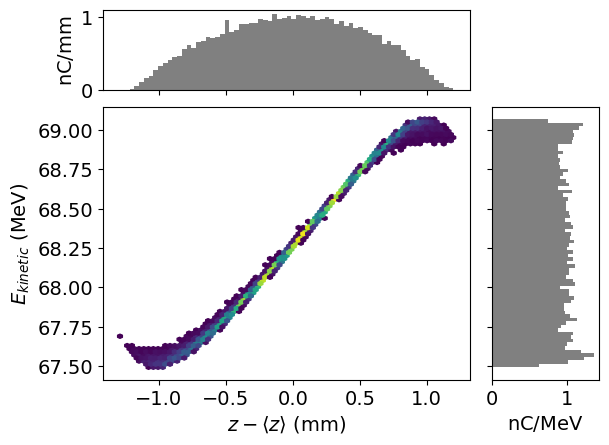

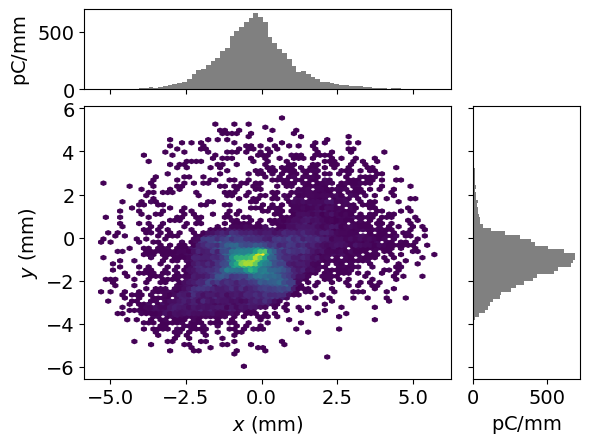

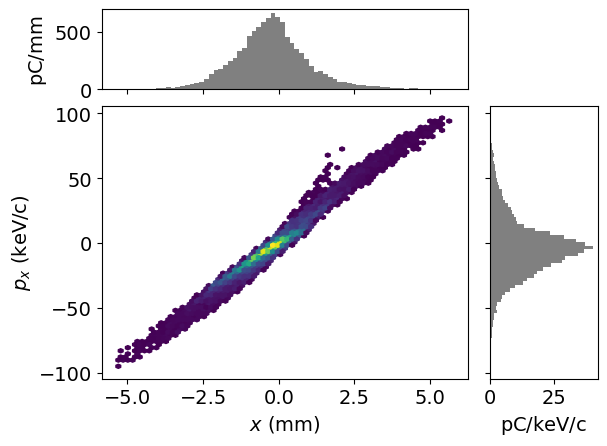

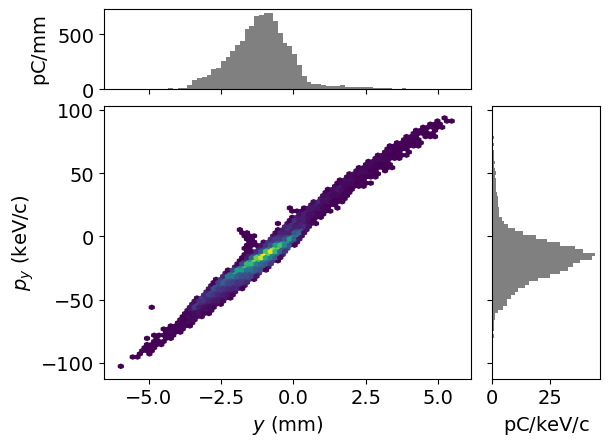

In [15]:
afile = f'{filepath}/archive.h5'
I=Impact()
I.load_archive(afile)
P=I.particles['L0AFEND']

P.plot('delta_z','kinetic_energy')
P.plot('x','y')


P.plot('x','px')
P.plot('y','py')
print(afile)

## Define Bmad function

In [16]:
def run_bmad(settings,locations,Bmad_CSR_Command):
    !echo $OMP_NUM_THREADS
    bunch={}
    tao=Tao('-init {:s}/bmad/models/f2_elec/tao.init -noplot'.format(environ['FACET2_LATTICE'])) 
    floorplan=pd.read_csv(io.StringIO('\n'.join(tao.show('lat -all -floor_coords -tracking_elements')[3:-5])), sep="[\s\n]+",engine='python',
            names=['Index','ElementName','ElementType','s','ds','X','Y','Z','Theta','Phi','Psi'])
    floorplan.drop(0,inplace=True)
    # print(settings['L0BF_Phase'])

    if 'L0BF_Phase:theta0_deg' in settings.columns:
        tao.cmd('set ele {} PHI0={}'.format('L0BF', (settings['L0BF_Phase:theta0_deg'].values)/360))
    if 'L0BF_E_Gain' in settings.columns:
        tao.cmd('set ele {} VOLTAGE={}'.format('L0BF', settings['L0BF_E_Gain'].values))

    if 'QA10361:b1_gradient' in settings.columns:
        tao.cmd('set ele {} B1_GRADIENT={}'.format('QA10361', (settings['QA10361:b1_gradient'].values)))
    if 'QA10371:b1_gradient' in settings.columns:
        tao.cmd('set ele {} B1_GRADIENT={}'.format('QA10371', (settings['QA10371:b1_gradient'].values)))
    if 'QA10425:b1_gradient' in settings.columns:
        tao.cmd('set ele {} B1_GRADIENT={}'.format('QE10425', (settings['QE10425:b1_gradient'].values)))
    if 'QA10441:b1_gradient' in settings.columns:
        tao.cmd('set ele {} B1_GRADIENT={}'.format('QE10441', (settings['QE10441:b1_gradient'].values)))
    if 'QA10511:b1_gradient' in settings.columns:
        tao.cmd('set ele {} B1_GRADIENT={}'.format('QE10511', (settings['QE10511:b1_gradient'].values)))
    if 'QA10525:b1_gradient' in settings.columns:
        tao.cmd('set ele {} B1_GRADIENT={}'.format('QE10525', (settings['QE10525:b1_gradient'].values)))
    
    # Find element strings matching L1, L2 and L3
    #These more general match strings might cause problems by including both lords and slaves!
    L1MatchStrings = ["K11_1*", "K11_2*"]
    L2MatchStrings = ["K11_4*", "K11_5*", "K11_6*", "K11_7*", "K11_8*", "K12_*", "K13_*", "K14_*"]
    L3MatchStrings = ["K15_*", "K16_*", "K17_*", "K18_*", "K19_*"]
    
    #Therefore, use lat_list and these general search strings to get specific elements
    #Recall that, by default, lat_list has the flag "-track_only" so lords are not included
    #But some of the tracking elements are super_slaves which cannot be `set`
    
    #"-array_out" flag is on by default but if flags are edited, need to re-add manually to get numeric values back
    
    L1MatchStrings = np.concatenate( [ tao.lat_list(i,"ele.name", flags="-no_slaves") for i in L1MatchStrings ] )
    L2MatchStrings = np.concatenate( [ tao.lat_list(i,"ele.name", flags="-no_slaves") for i in L2MatchStrings ] )
    L3MatchStrings = np.concatenate( [ tao.lat_list(i,"ele.name", flags="-no_slaves") for i in L3MatchStrings ] )
    
    # Phase L1
    setLinacPhase(L1MatchStrings, settings['L1phase'].values,tao)
    setLinacGradientAuto( L1MatchStrings, settings['L1energy'].values - settings['L0energy'].values,tao )
    
    # Phase L2
    setLinacPhase(L2MatchStrings, settings['L2phase'].values,tao)
    setLinacGradientAuto( L2MatchStrings, settings['L2energy'].values - settings['L1energy'].values ,tao)
    
    tao.cmd('set beam_init position_file='+settings['startfile'].values[0])
    tao.cmd('reinit beam')
    
    tao.beam_init()['position_file']
    tao.cmd('call Activate_CSR.tao');
    
    tao.cmd(Bmad_CSR_Command)
    tao.cmd('set global track_type = beam') 
    
    # print(settings['startfile'].index)
    P=[]
    for location in locations:
        Ptemp = ParticleGroup(data=tao.bunch_data(location))
        # Select out live particles
        Ptemp = Ptemp[Ptemp.status==1]
        Ptemp.drift_to_z()
        P.append(Ptemp)
    bunch['P']=P
    return bunch

## Prepare Bmad Settings for Run

In [17]:
filepath=FILEPATH+NAME
Bmad_Settings=pd.DataFrame(Bmad_Settings,index=[0]).head()
Bmad_Settings['startfile']=filepath+'/L0AFEND.h5'

In [18]:
print('set beam_init position_file='+Bmad_Settings['startfile'].values[0])

set beam_init position_file=/sdf/data/ad/ard/u/cropp/Sol_Scan_FACET1/1.6nC_s2e_200k_Timing_Test/L0AFEND.h5


## Run Bmad

In [19]:
%%time
bmad_results=run_bmad(Bmad_Settings,locations,Bmad_CSR_Command)

119
CPU times: user 19min 43s, sys: 7.6 s, total: 19min 50s
Wall time: 31.3 s


## Archive Bmad

In [20]:
output = open(filepath+'/bmad.pkl', 'wb')
pickle.dump(bmad_results,output)
output.close()

## Check Timing

In [21]:
et=time.time()
elapsed_time=et-st

print('Execution time:', elapsed_time, 'seconds')

Execution time: 73.10448455810547 seconds


## Plot LPS at different locations

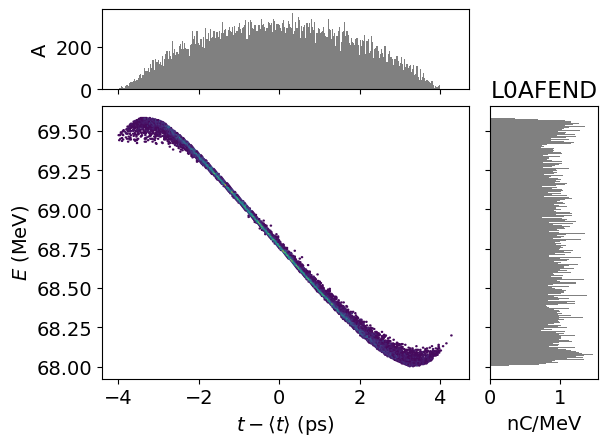

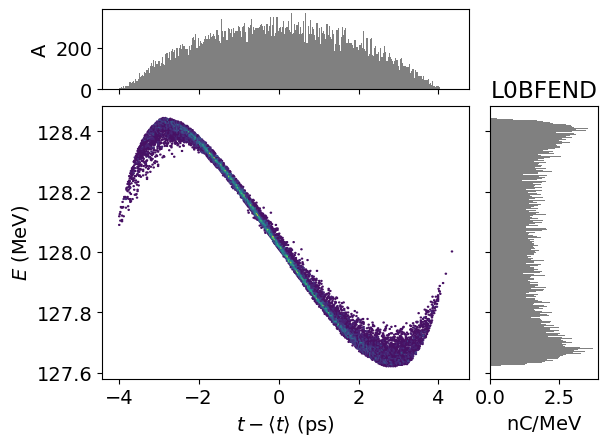

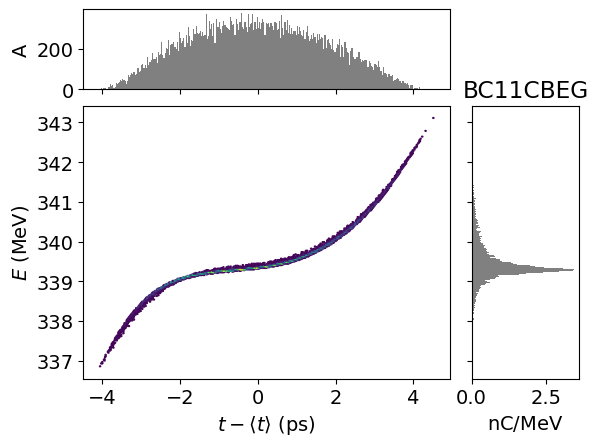

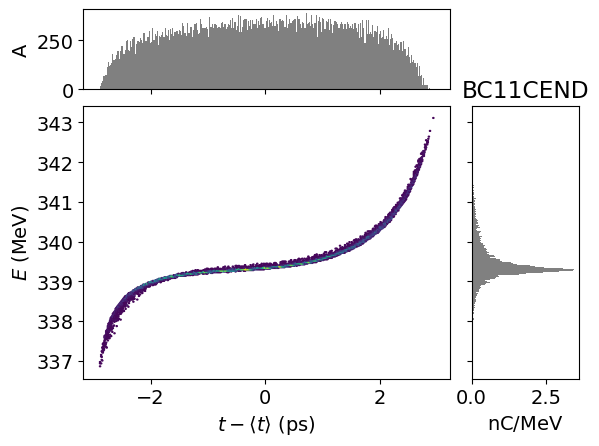

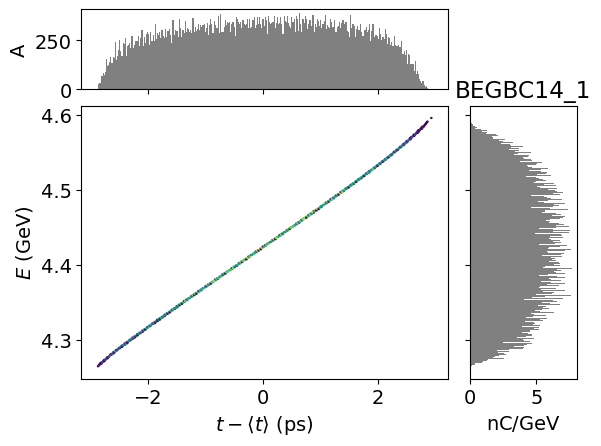

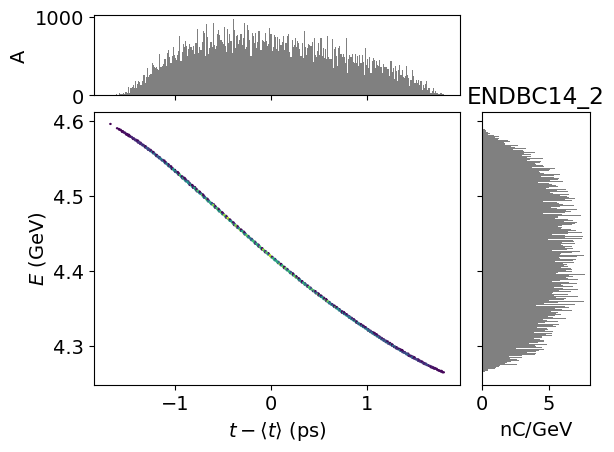

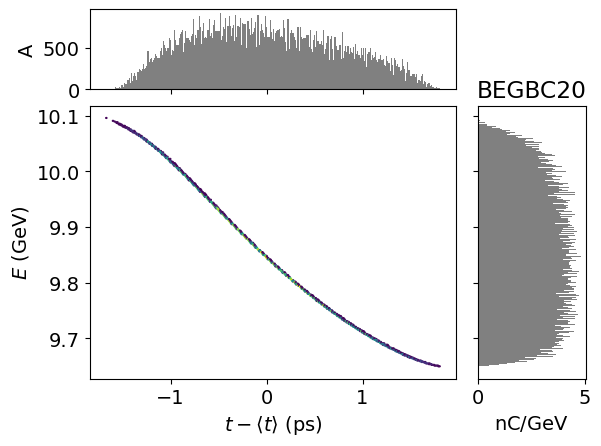

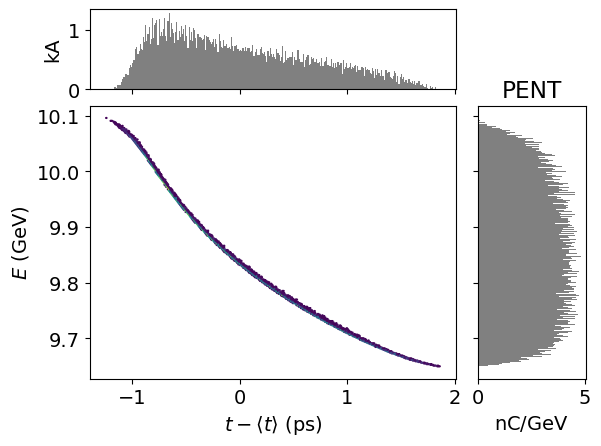

In [22]:
for i in range(len(locations)):
    P = bmad_results['P'][i]
    # Select out live particles
    P = P[P.status==1]
    P.drift_to_z()
    # General lPS plot and transverse profile
    P.plot('delta_t', 'energy',bins=300)
    plt.title(locations[i])

## Remove copied files


In [23]:
!rm -rf ImpactT_template.in
!rm -rf rfdata201
!rm -rf rfdata102
!rm -rf rfdata4
!rm -rf rfdata5
!rm -rf rfdata6
!rm -rf rfdata7
!rm -rf ImpactT.yaml